<a href="https://colab.research.google.com/github/suranjan-das/face_detection_pytorch_cnn/blob/main/torch_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pytorch project: Detecting human emotion from facial expression

In [ ]:
from zipfile import ZipFile

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/pytorch/torch project 1/archive.zip"

# unzip data directory into corresponding folders
with ZipFile(data_path, 'r') as data_zip:
  data_zip.extractall("./data")

##About Dataset FER2013  ![](https://storage.googleapis.com/kaggle-datasets-images/786787/1351797/89e6e907cb903b4f523bbd613e46b8a8/dataset-cover.png?t=2020-07-19-18-42-52)
The data consists of **48x48** pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories `(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)`. The training set consists of 28,709 examples and the public test set consists of 3,589 examples

[kaggle source](https://www.kaggle.com/datasets/msambare/fer2013)

In [ ]:
!pip install directory_tree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# print data directory structure
from directory_tree import display_tree

display_tree('data', max_depth=2)

data/
├── test/
│   ├── angry/
│   ├── disgust/
│   ├── fear/
│   ├── happy/
│   ├── neutral/
│   ├── sad/
│   └── surprise/
└── train/
    ├── angry/
    ├── disgust/
    ├── fear/
    ├── happy/
    ├── neutral/
    ├── sad/
    └── surprise/


Load dataset and transform for feeding it to CNN model

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models

from torch.utils.data import DataLoader
from torch.utils.data import Subset

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import numpy as np
import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def prepare_data(path, training_transform, validation_transform, validation_size = 0.25, BATCH_SIZE = 64):
    data = datasets.ImageFolder(root=path) # load data from folder

    # get training and validation indices by shuffling
    np.random.seed(21)
    indices = list(range(len(data))) # get indices
    np.random.shuffle(indices) # shuffle the indices

    split = int(np.floor(validation_size * len(data)))
    # create training and validation indices list
    train_idx, valid_idx = indices[split:], indices[:split]

    # split the dataset
    training_dataset = Subset(data, train_idx)
    validation_dataset = Subset(data, valid_idx)

    # apply transform
    training_dataset.dataset.transform = training_transform
    validation_dataset.dataset.transform = validation_transform

    # load the the data into loader
    # create training loader
    train_loader = DataLoader(
        training_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=4, persistent_workers= True
    )
    # create validation loader
    valid_loader = DataLoader(
        validation_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=4, persistent_workers= True
    )

    # return the loaders
    return (train_loader, valid_loader)

In [ ]:
# define transform for initial image processing

# training transform
training_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Grayscale(num_output_channels=1),
     transforms.Normalize((0.5,),(0.5,))]
)

#validation transfrom
validation_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Grayscale(num_output_channels=1),
     transforms.Normalize((0.5,),(0.5,))]
)

In [ ]:
train_loader, valid_loader = prepare_data("./data/train", training_transform, validation_transform)

Visulaize the training dataset and validation dataset

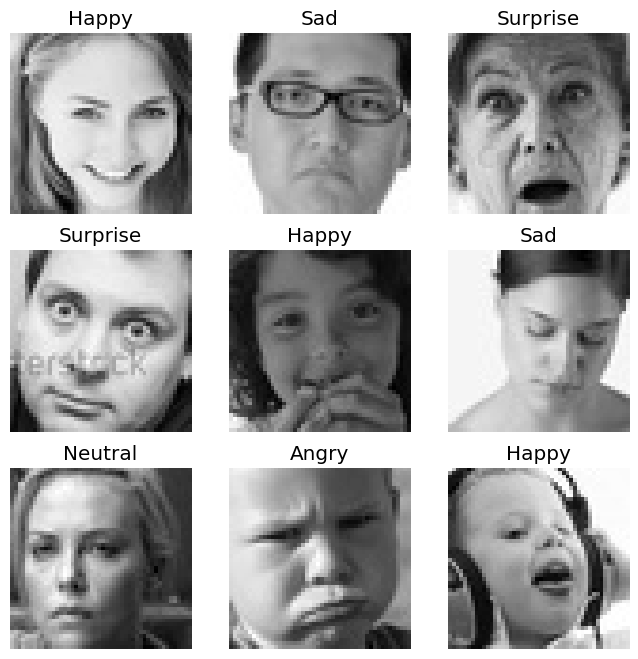

In [ ]:
labels_map = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Neutral",
    5: "Sad",
    6: "Surprise"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  # get random sample id
  sample_idx = torch.randint(len(train_loader), size=(1,)).item()
  img, label = next(iter(train_loader))
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label[0].item()])
  plt.axis("off")
  plt.imshow(img[0].squeeze(), cmap="gray")
plt.show()

### Let's build our model
The approach will be to start with relatively simple model and incrementally increase it's complexcities

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

let's create a helper function to plot taining accuracy and loss with validation

In [ ]:
# helper class for early stopping
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.previous_acc = 0
        self.current_acc = 0

    def __call__(self, accuracy):
        self.previous_acc = self.current_acc
        self.current_acc = accuracy

        if self.current_acc - self.previous_acc < self.min_delta:
            self.counter += 1
        else:
            self.counter = 0

        if self.counter >= self.tolerance:
            self.early_stop = True

In [ ]:
# write training and validaton training loop helper function for single epoch
def train(model, trainloader, optimizer, criterion):
    # set model to training mode
    model.train()
    train_running_loss = 0
    train_running_correct = 0
    counter = 0
    for i, data in enumerate(trainloader):
        counter += 1
        images, labels = data
        # send it to computing device
        images = images.to(device)
        labels = labels.to(device)
        # reset gradients
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        # calculate loss
        loss = criterion(output, labels)
        # accumulate loss
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
# validation
def validate(model, testloader, criterion):
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
def train_n_validate(model, loader, criterion, optimizer, epochs = 10, scheduler = None, verbose = 0):
    # lists to keep track of losses and accuracies
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    train_loader, valid_loader = loader
    # instantiate earlystopping class
    # stop training if validation accuracy does not improve
    # by 1% for 3 epochs
    early_stopping = EarlyStopping(tolerance=3, min_delta=1)

    # start the training
    for epoch in range(epochs):
        if verbose > 0: print("training...")
        train_epoch_loss, train_epoch_acc = train(model, train_loader,
                                                    optimizer, criterion)
        if verbose > 0: print("validating...")
        valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,
                                                        criterion)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        if scheduler:
            scheduler.step()
        if verbose > 0:
            print(f"\n[INFO]: Epoch {epoch+1} of {epochs}")
            print(f"training loss: {train_epoch_loss:.3f}, training accuracy: {train_epoch_acc:.3f}")
            print(f"validation loss: {valid_epoch_loss:.3f}, validation accuracy: {valid_epoch_acc:.3f}")
            print('-'*50)
        # early stopping
        early_stopping(valid_epoch_acc)
        if early_stopping.early_stop:
            print("training stopped early at epoch:", epoch)
            break

    return((train_acc, valid_acc), (train_loss, valid_loss))

In [ ]:
def plot_progress(train_acc, valid_acc, train_loss, valid_loss):
  """
  Function to plot the loss and accuracy.
  """
  figure = plt.figure(figsize=(10, 4))
  # accuracy plots
  figure.add_subplot(1, 2, 1)
  plt.plot(
      train_acc, color='green', linestyle='-',
      label='train accuracy'
  )
  plt.plot(
      valid_acc, color='blue', linestyle='-',
      label='validataion accuracy'
  )
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # loss plots
  figure.add_subplot(1, 2, 2)
  plt.plot(
      train_loss, color='orange', linestyle='-',
      label='train loss'
  )
  plt.plot(
      valid_loss, color='red', linestyle='-',
      label='validataion loss'
  )
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

### LeNet5
First we will use classic LeNet5 architecture as our baseline model
<p>Here is its architecture.</p>
<p>In our case input size is <strong>48x48</strong> and output size is <strong>7</strong></p>


![](https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-18-12-52-17.png)

In [ ]:
# build model
class leNet(nn.Module):

  def __init__(self):
    super(leNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(16 * 9 * 9, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 7)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.flat(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
# set available device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Available computation device: {device}")

# instantiate model
model = leNet().to(device)
print(model)

# print model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"total number of model parameters: {total_params}")

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total number of trainable model parameters: {total_trainable_params}")

Available computation device: cuda
leNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)
total number of model parameters: 168971
total number of trainable model parameters: 168971


In [ ]:
loader = prepare_data("./data/train", training_transform, validation_transform)

In [ ]:
# instantiate model
model = leNet().to(device)

# set training parameters
lr = 5e-3
epochs = 20
# optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

# train
(train_acc, valid_acc), (train_loss, valid_loss) = train_n_validate(model, loader, criterion,
                                                                    optimizer, epochs = epochs, verbose = 1)

training...
validating...

[INFO]: Epoch 1 of 20
training loss: 1.798, training accuracy: 25.516
validation loss: 1.733, validation accuracy: 30.291
--------------------------------------------------
training...
validating...

[INFO]: Epoch 2 of 20
training loss: 1.675, training accuracy: 33.513
validation loss: 1.636, validation accuracy: 35.474
--------------------------------------------------
training...
validating...

[INFO]: Epoch 3 of 20
training loss: 1.600, training accuracy: 37.461
validation loss: 1.613, validation accuracy: 35.934
--------------------------------------------------
training...
validating...

[INFO]: Epoch 4 of 20
training loss: 1.533, training accuracy: 40.767
validation loss: 1.521, validation accuracy: 41.117
--------------------------------------------------
training...
validating...

[INFO]: Epoch 5 of 20
training loss: 1.473, training accuracy: 43.428
validation loss: 1.477, validation accuracy: 42.957
--------------------------------------------------


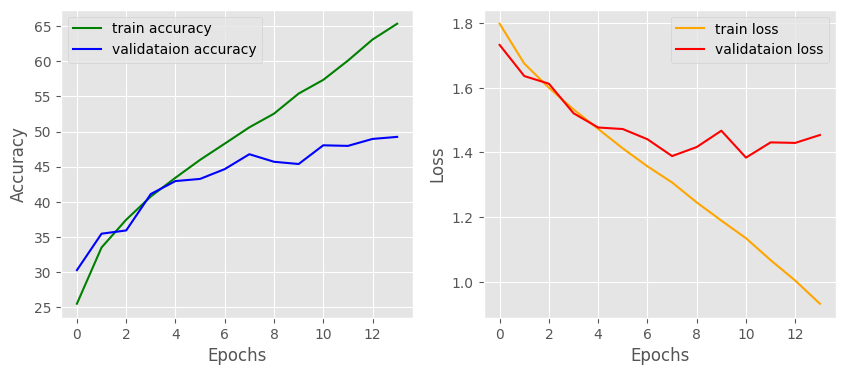

In [ ]:
plot_progress(train_acc, valid_acc, train_loss, valid_loss)

$Note$
- Even with this simple neural architecture this model is overfitting
- After epoch 5 validation loss stopped impeoving
- We will try different regulerazitation technique

### With `Dropout`

In [ ]:
# build model with dropout regulerization
class leNet_reg1(nn.Module):

  def __init__(self):
    super(leNet_reg1, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.flat = nn.Flatten()
    self.do = nn.Dropout(0.2)
    self.fc1 = nn.Linear(16 * 9 * 9, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 7)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.do(x)
    x = self.flat(x)
    x = F.relu(self.fc1(x))
    x = self.do(x)
    x = F.relu(self.fc2(x))
    x = self.do(x)
    x = self.fc3(x)
    return x

In [ ]:
# instantiate model
model_reg1 = leNet_reg1().to(device)
print(model_reg1)

# print model parameters
total_params = sum(p.numel() for p in model_reg1.parameters())
print(f"total number of model parameters: {total_params}")

total_trainable_params = sum(p.numel() for p in model_reg1.parameters() if p.requires_grad)
print(f"total number of trainable model parameters: {total_trainable_params}")

leNet_reg1(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (do): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)
total number of model parameters: 168971
total number of trainable model parameters: 168971


In [ ]:
# instantiate model
model_reg1 = leNet_reg1().to(device)

# set training parameters
lr = 5e-3
epochs = 20
# optimizer
optimizer = optim.SGD(model_reg1.parameters(), lr=lr, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

# train
(train_acc, valid_acc), (train_loss, valid_loss) = train_n_validate(model_reg1, loader, criterion,
                                                                    optimizer, epochs = epochs, verbose = 1)

training...
validating...

[INFO]: Epoch 1 of 20
training loss: 1.826, training accuracy: 24.568
validation loss: 1.782, validation accuracy: 25.763
--------------------------------------------------
training...
validating...

[INFO]: Epoch 2 of 20
training loss: 1.746, training accuracy: 28.706
validation loss: 1.683, validation accuracy: 33.036
--------------------------------------------------
training...
validating...

[INFO]: Epoch 3 of 20
training loss: 1.670, training accuracy: 34.168
validation loss: 1.613, validation accuracy: 36.673
--------------------------------------------------
training...
validating...

[INFO]: Epoch 4 of 20
training loss: 1.607, training accuracy: 37.233
validation loss: 1.580, validation accuracy: 38.178
--------------------------------------------------
training...
validating...

[INFO]: Epoch 5 of 20
training loss: 1.554, training accuracy: 39.485
validation loss: 1.522, validation accuracy: 39.975
--------------------------------------------------


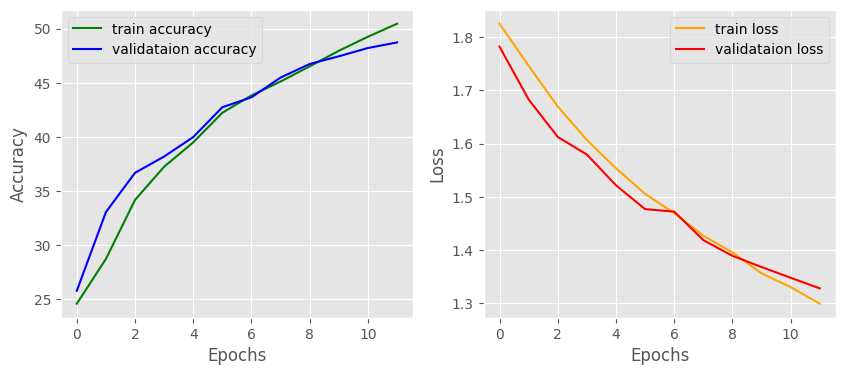

In [ ]:
plot_progress(train_acc, valid_acc, train_loss, valid_loss)

### $Note$
- With dropout layer the model is able to push validation score upto epoch 11/12. But still it falls short of the desired level of accuracy
- Let us see effect of image augmentation

### Image augmentation

In [ ]:
training_augment = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
    transforms.RandomRotation(30),
    # transforms.RandomResizedCrop(48),
    transforms.RandomHorizontalFlip(0.5)]
)

In [ ]:
augment_loader = prepare_data("./data/train", training_augment, validation_transform)

In [ ]:
# instantiate model
model_aug = leNet().to(device)

# set training parameters
lr = 5e-3
epochs = 20
# optimizer
optimizer = optim.SGD(model_aug.parameters(), lr=lr, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

# train
(train_acc, valid_acc), (train_loss, valid_loss) = train_n_validate(model_aug, augment_loader, criterion,
                                                                    optimizer, epochs = epochs, verbose = 1)

training...
validating...

[INFO]: Epoch 1 of 20
training loss: 1.819, training accuracy: 24.452
validation loss: 1.768, validation accuracy: 25.930
--------------------------------------------------
training...
validating...

[INFO]: Epoch 2 of 20
training loss: 1.715, training accuracy: 30.907
validation loss: 1.705, validation accuracy: 31.225
--------------------------------------------------
training...
validating...

[INFO]: Epoch 3 of 20
training loss: 1.638, training accuracy: 35.477
validation loss: 1.608, validation accuracy: 36.617
--------------------------------------------------
training...
validating...

[INFO]: Epoch 4 of 20
training loss: 1.568, training accuracy: 39.328
validation loss: 1.579, validation accuracy: 37.996
--------------------------------------------------
training...
validating...

[INFO]: Epoch 5 of 20
training loss: 1.505, training accuracy: 41.752
validation loss: 1.509, validation accuracy: 40.992
--------------------------------------------------


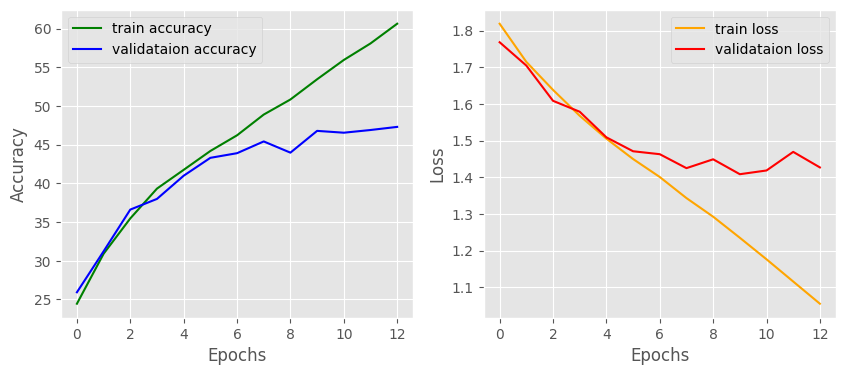

In [ ]:
plot_progress(train_acc, valid_acc, train_loss, valid_loss)

### $Note$
- with dataset augmentation we could address the overfitting problem, but the accuracy score is not improving beyond 50%
- we need to increse the model complexity to get more accurate result

### $AlexNet$ architecture
![](https://www.oreilly.com/api/v2/epubs/9781789956177/files/assets/ec08175c-5282-4be2-b6e7-6f2d99272166.png)

In [ ]:
# define transform for initial image processing

# training transform
alex_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,)),
        transforms.Resize(128),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomResizedCrop(128),]
)
# validation transform
alex_valid_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,)),
        transforms.Resize(128)]
)

In [ ]:
alex_loader = prepare_data("./data/train", alex_transform, alex_valid_transform)

In [ ]:
# load alexnet
model_alex = models.alexnet(pretrained=True).to(device)
# for param in model_conv.parameters():
#     param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_alex.classifier[6].in_features
model_alex.fc = nn.Linear(num_ftrs, 7)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:12<00:00, 19.1MB/s]


In [ ]:
# set training parameters
lr = 5e-3
epochs = 20
# optimizer
optimizer = optim.SGD(model_alex.parameters(), lr=lr, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

# train
(train_acc, valid_acc), (train_loss, valid_loss) = train_n_validate(model_alex, alex_loader, criterion,
                                                                    optimizer, epochs = epochs, verbose = 1)

training...
validating...

[INFO]: Epoch 1 of 20
training loss: 1.848, training accuracy: 31.558
validation loss: 1.591, validation accuracy: 40.226
--------------------------------------------------
training...
validating...

[INFO]: Epoch 2 of 20
training loss: 1.369, training accuracy: 47.998
validation loss: 1.371, validation accuracy: 47.819
--------------------------------------------------
training...
validating...

[INFO]: Epoch 3 of 20
training loss: 1.236, training accuracy: 52.768
validation loss: 1.222, validation accuracy: 53.797
--------------------------------------------------
training...
validating...

[INFO]: Epoch 4 of 20
training loss: 1.132, training accuracy: 56.939
validation loss: 1.228, validation accuracy: 53.880
--------------------------------------------------
training...
validating...

[INFO]: Epoch 5 of 20
training loss: 1.049, training accuracy: 60.398
validation loss: 1.217, validation accuracy: 55.288
--------------------------------------------------


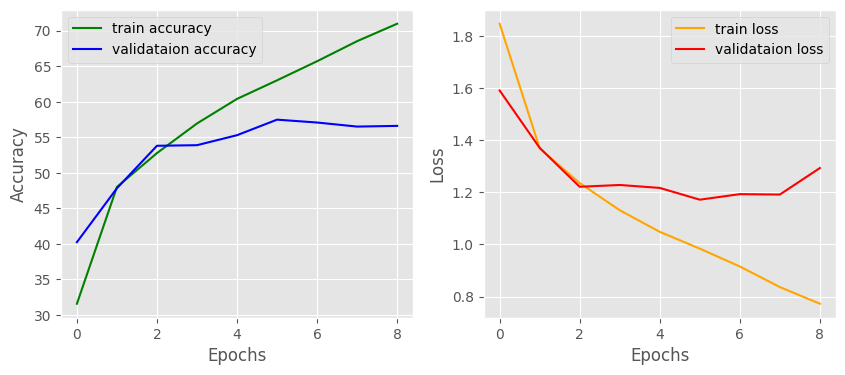

In [ ]:
plot_progress(train_acc, valid_acc, train_loss, valid_loss)

In [ ]:
model_vgg = models.vgg11(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
fc_layer = model_vgg.classifier[6]
num_ftrs = fc_layer.in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs, 7)

model_vgg = model_vgg.to(device)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:10<00:00, 50.3MB/s]


In [ ]:
# set training parameters
lr = 1e-3
epochs = 20
# optimizer
optimizer = optim.SGD(model_vgg.parameters(), lr=lr, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

# train
(train_acc, valid_acc), (train_loss, valid_loss) = train_n_validate(model_vgg, alex_loader, criterion,
                                                                    optimizer, epochs = epochs, verbose = 1)

training...
validating...

[INFO]: Epoch 1 of 20
training loss: 1.436, training accuracy: 44.376
validation loss: 1.251, validation accuracy: 52.069
--------------------------------------------------
training...
validating...

[INFO]: Epoch 2 of 20
training loss: 1.173, training accuracy: 55.424
validation loss: 1.145, validation accuracy: 55.748
--------------------------------------------------
training...
validating...

[INFO]: Epoch 3 of 20
training loss: 1.062, training accuracy: 59.679
validation loss: 1.085, validation accuracy: 58.813
--------------------------------------------------
training...
validating...

[INFO]: Epoch 4 of 20
training loss: 0.974, training accuracy: 63.362
validation loss: 1.052, validation accuracy: 59.830
--------------------------------------------------
training...
validating...

[INFO]: Epoch 5 of 20
training loss: 0.899, training accuracy: 66.278
validation loss: 1.053, validation accuracy: 60.568
--------------------------------------------------


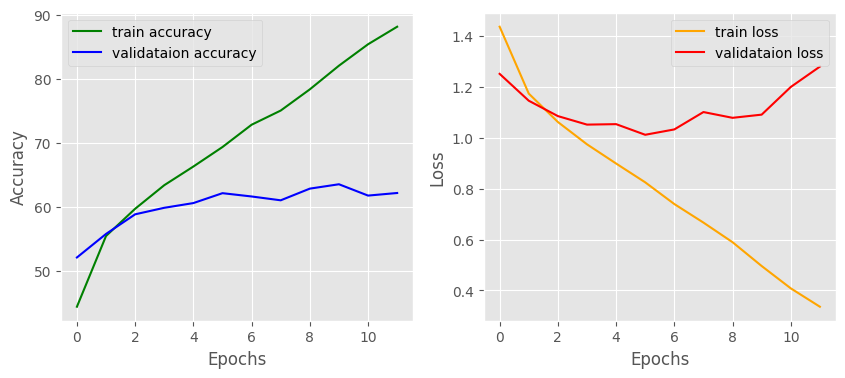

In [ ]:
plot_progress(train_acc, valid_acc, train_loss, valid_loss)

In [ ]:
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

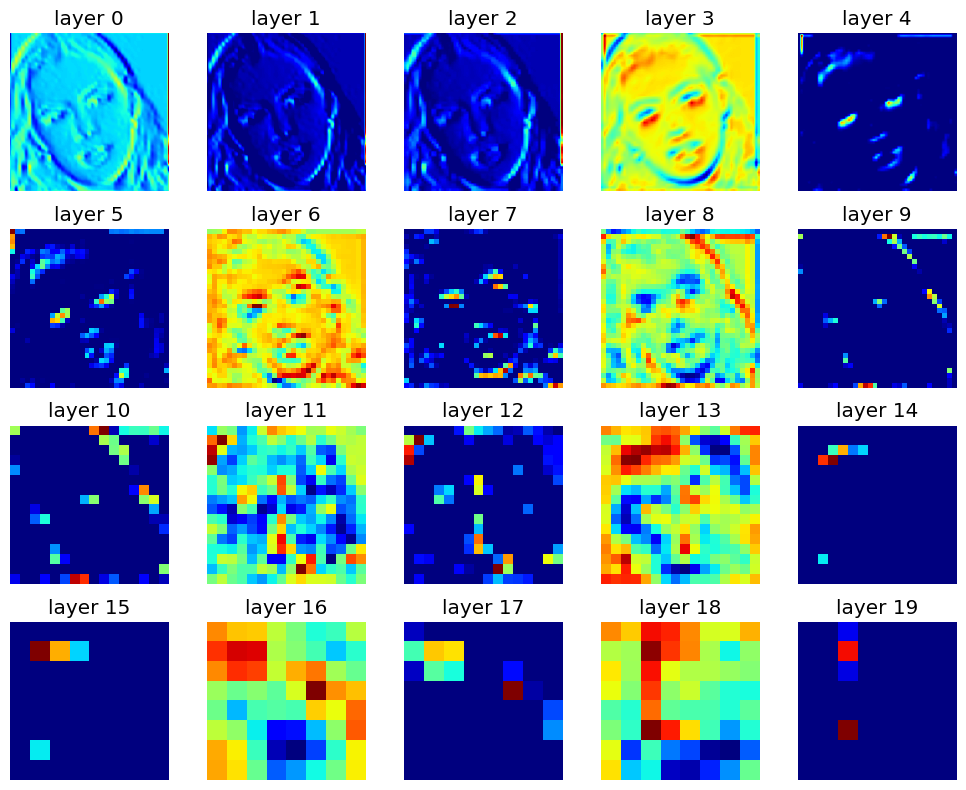

In [ ]:
t = next(iter(alex_loader[0]))
im = t[0][0][0].detach()

nrow, ncol = 4, 5
fig, axs = plt.subplots(nrow, ncol, figsize=(10,8))

# title = labels_map[t[1][0].item()]
# plt.imshow(im, cmap='gray')
# plt.title(title)
# plt.axis('off')

sequential = model_vgg.features
x = t[0].to(device)

layer_num = 20
for i in range(layer_num):
    r, c = i//(nrow+1), i%ncol
    x = sequential[i](x)
    a = axs[r,c]
    a.imshow(x[0][0].to('cpu').detach(), cmap='jet')
    a.set_title(f'layer {i}')
    a.axis('off');
fig.tight_layout()